# Atividade 11b - Treinar um classificador SVM

Matheus Xavier Sampaio           RA: 220092

Guilherme Augusto Amorim Terrell RA: 168899


Esta atividade tem como objetivo: 
 
* que permita, dada uma imagem com lesão, classificá-la como lesão "isquêmica" (AVC) ou "desmielinizante" (EM)

## Bibliotecas e funções auxiliares

In [1]:
from __future__ import annotations

from collections import defaultdict
from itertools import chain
from pathlib import Path

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps
from scipy import stats
from skimage.feature import greycomatrix, greycoprops, local_binary_pattern
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    RocCurveDisplay
)
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from tqdm.auto import tqdm

In [2]:
FIGURES = Path('/content/drive/MyDrive/Train')

In [3]:
def read_img(path: str, grayscale: bool = True) -> np.array:
    img = Image.open(FIGURES / path)
    if grayscale:
        img = ImageOps.grayscale(img)
    return np.asarray(img)

In [4]:
def get_file_paths(dirname, exts, dir=FIGURES):
    if isinstance(exts, str):
        exts = [exts]
    
    files = []
    for ext in exts:
        files.extend((dir / dirname).glob(f'*.{ext}'))
    return files

## Leitura das imagens

In [5]:
avc_images = get_file_paths('AVC', ['bmp', 'png'])
em_images = get_file_paths('EM', ['bmp', 'png'])

In [6]:
len(avc_images), len(em_images)

(2056, 2974)

In [7]:
avc_brain = list(filter(lambda x: 'mask' not in str(x), avc_images))
em_brain = list(filter(lambda x: 'mask' not in str(x), em_images))

In [8]:
len(avc_brain), len(em_brain)

(1475, 2344)

In [9]:
avc_masks = list(filter(lambda x: 'mask' in str(x), avc_images))
em_masks = list(filter(lambda x: 'mask' in str(x), em_images))

In [10]:
len(avc_masks), len(em_masks)

(581, 630)

Para AVC, temos 1475 imagens e 581 máscaras.

Para EM, temos 2344 imagens e 630 máscaras.

Agora, agruparemos as imagens e máscaras por cada paciente.

In [11]:
avc_mask_patients = defaultdict(list)

for img in avc_masks:
    pct = img.stem.split('_')[0]
    flair = img.stem.split('_')[1]
    avc_mask_patients[pct].append(flair)

len(avc_mask_patients)

50

In [12]:
em_mask_patients = defaultdict(list)

for img in em_masks:
    pct = img.stem.split('_')[0]
    flair = img.stem.split('_')[1]
    em_mask_patients[pct].append(flair)

len(em_mask_patients)

51

Estes são exemplos de imagens que possuem mascara para dois pacientes, um de AVC e um de EM.

In [13]:
avc_mask_patients['001'], em_mask_patients['060']

(['FLAIR18', 'FLAIR19', 'FLAIR20', 'FLAIR21'],
 ['FLAIR13',
  'FLAIR14',
  'FLAIR15',
  'FLAIR16',
  'FLAIR17',
  'FLAIR18',
  'FLAIR19',
  'FLAIR20',
  'FLAIR21',
  'FLAIR22'])

Apenas algumas imagens possuem máscara, o que indica que apenas em algumas imagens podemos observar lesão. Filtraremos as imagens para conter apenas aquelas que apresentam lesão.

In [14]:
avc_patients = defaultdict(list)

for img in avc_brain:
    pct = img.stem.split('_')[0]
    flair = img.stem.split('_')[1]
    if flair in avc_mask_patients[pct]:
        avc_patients[pct].append(img)

In [15]:
em_patients = defaultdict(list)

for img in em_brain:
    pct = img.stem.split('_')[0]
    flair = img.stem.split('_')[1]
    if flair in em_mask_patients[pct]:
        em_patients[pct].append(img)

In [16]:
avc_patients['001']

[PosixPath('/content/drive/MyDrive/Train/AVC/001_FLAIR18.bmp'),
 PosixPath('/content/drive/MyDrive/Train/AVC/001_FLAIR19.bmp'),
 PosixPath('/content/drive/MyDrive/Train/AVC/001_FLAIR20.bmp'),
 PosixPath('/content/drive/MyDrive/Train/AVC/001_FLAIR21.bmp')]

In [17]:
em_patients['060']

[PosixPath('/content/drive/MyDrive/Train/EM/060_FLAIR13.bmp'),
 PosixPath('/content/drive/MyDrive/Train/EM/060_FLAIR14.bmp'),
 PosixPath('/content/drive/MyDrive/Train/EM/060_FLAIR15.bmp'),
 PosixPath('/content/drive/MyDrive/Train/EM/060_FLAIR16.bmp'),
 PosixPath('/content/drive/MyDrive/Train/EM/060_FLAIR17.bmp'),
 PosixPath('/content/drive/MyDrive/Train/EM/060_FLAIR18.bmp'),
 PosixPath('/content/drive/MyDrive/Train/EM/060_FLAIR19.bmp'),
 PosixPath('/content/drive/MyDrive/Train/EM/060_FLAIR20.bmp'),
 PosixPath('/content/drive/MyDrive/Train/EM/060_FLAIR21.bmp'),
 PosixPath('/content/drive/MyDrive/Train/EM/060_FLAIR22.bmp')]

## Features e preparação dos dados de treino

Como features, ecolhemos utilizar as seguintes estatisticas de histograma:
- Desvio padrão
- Variância
- Mediana
- Moda
- Skewness
- Kurtosis
- Entropia

Estas foram calculadas no histograma da imagem e no histograma do LBP. Também utilizamos o valor de contraste da Matrix de Coocorrencia. O algorítmo para calculo para características do GLRLM apresentou tempo de execução muito elevado, assim, resolvemos não utilizar este.

Os valores utilizados no LBP e Matriz de Coocorrencia foram escolhidos de acordo com os experimentos nas atividades anteriores. Também de acordo com os experimentos, resolvemos não aplicar normalização nas imagens.

In [18]:
def calc_histogram_statistics(hist):
    return [
        np.std(hist),
        np.var(hist),
        stats.mode(hist, axis=None).mode[0],
        np.median(hist),
        stats.skew(hist),
        stats.kurtosis(hist),
        stats.entropy(hist)
    ]

In [19]:
def features_generator(data):
    images_patient = [
        [k] * len(v) for k, v in data.items()
    ]
    images_patient = list(chain(*images_patient))
    images_paths = list(chain(*data.values()))

    features = defaultdict(list)
    for p, img in tqdm(zip(images_patient, images_paths), total=len(images_patient)):
        img_array = read_img(img)
    
        hist, _ = np.histogram(img_array, bins=50)

        hist_stats = calc_histogram_statistics(hist)
        contrast = greycoprops(
            greycomatrix(img_array.copy(), distances=[15], angles=[45, 90, 135], levels=256, symmetric=True, normed=True),
            prop='contrast'
        )[0]
        lbp_histogram, _ = np.histogram(local_binary_pattern(img_array, 8 * 3, 3, 'uniform'), bins=50)
        lbp_hist_stats = calc_histogram_statistics(lbp_histogram)

        feats = list(contrast) + list(hist_stats) + list(lbp_hist_stats)         
        features[p].append(feats)

    return features

In [20]:
avc_features = features_generator(avc_patients)
em_features = features_generator(em_patients)

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/628 [00:00<?, ?it/s]

Para lidar com os multiplos pacientes, e para dados de pacientes não estarem presentes no treino e validação, adotamos a estratégia de separar os dados de treinamento de acordo com os identificadores dos pacientes.

Cada iteração do KFold irá dividir os conjuntos de identificadores em treino e validação. Estes ids serão fornecidos com as caracteristicas, que serão transformadas de modo que possam ser fornecidas ao classificador.

O classificador usará 0 como AVC e 1 como EM. Apos gerar o X e y de treino, realizamos a normalização dos dados para que todas as caraceterísticas apresentem uma faixa de valores semelhante.

In [28]:
def generate_x_y(ids_avc, avc_p, ids_em, em_p, shuffle=True):
    X_avc = list(chain(*[avc_p[i] for i in ids_avc]))
    y_avc = [0] * len(X_avc)

    X_em = list(chain(*[em_p[i] for i in ids_em]))

    y_em = [1] * len(X_em)

    X = np.array(X_avc + X_em)
    y = np.array(y_avc + y_em)

    if shuffle:
        idx = np.random.permutation(len(y))
        X = X[idx]
        y = y[idx]

    return X, y

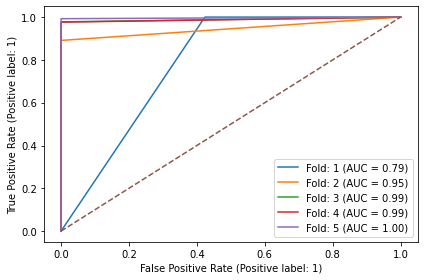

Acurácia do SVM após 5 folds: 90.17 % (±14.84)
Precisão do SVM após 5 folds: 83.23 % (±33.54)
Revocação do SVM após 5 folds: 96.76 % (±3.93)
F1 do SVM após 5 folds: 83.87 % (±28.09)


In [30]:
k = 5
kf = KFold(n_splits=k)
avc_ids = np.array(list(avc_patients.keys()))
em_ids = np.array(list(em_patients.keys()))

fold_metrics = defaultdict(list)
fig, ax = plt.subplots()

for i, ((train_avc, val_avc), (train_em, val_em)) in enumerate(zip(kf.split(avc_ids), kf.split(em_ids)), start=1):
    X_train, y_train = generate_x_y(avc_ids[train_avc], avc_features, em_ids[train_em], em_features, shuffle=True)
    X_val, y_val = generate_x_y(avc_ids[val_avc], avc_features, em_ids[val_em], em_features, shuffle=False)

    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)

    clf = SVC(kernel='linear')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    fold_metrics['Acurácia'].append((accuracy_score(y_pred, y_val) * 100))
    fold_metrics['Precisão'].append((precision_score(y_pred, y_val) * 100))
    fold_metrics['Revocação'].append((recall_score(y_pred, y_val) * 100))
    fold_metrics['F1'].append((f1_score(y_pred, y_val) * 100))

    RocCurveDisplay.from_predictions(y_pred, y_val, ax=ax, name=f'Fold: {i}')

ax.plot([0.0, 1.0], [0.0, 1.0], linestyle='dashed')
fig.tight_layout()
plt.show()

for m, v in fold_metrics.items():
    print(f'{m} do SVM após {k} folds: {np.mean(v):.2f} % (±{np.std(v):.2f})')

In [34]:
X_train, y_train = generate_x_y(avc_ids, avc_features, em_ids, em_features, shuffle=True)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
clf = SVC(kernel='linear')
clf.fit(X_train, y_train)

SVC(kernel='linear')

In [35]:
from joblib import dump, load
dump(clf, 'brain-classifier.joblib')
dump(scaler, 'brain-scaler.joblib')

['brain-scaler.joblib']

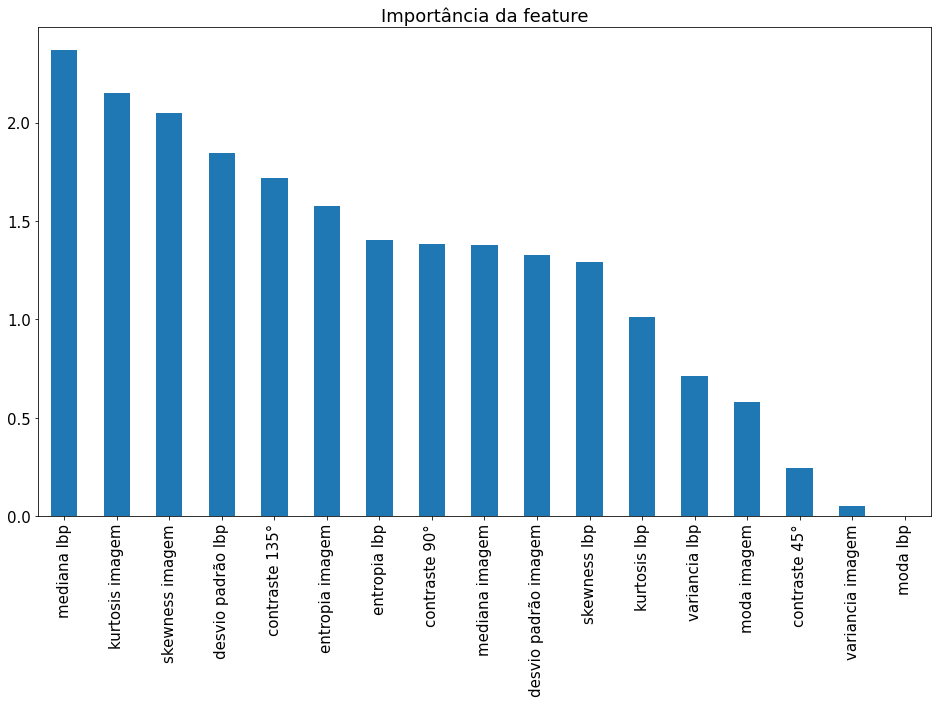

In [36]:
import pandas as pd

plt.figure(figsize=(16, 9))
plt.rcParams.update({'font.size': 15})
feat_names = [
 'contraste 45°', 'contraste 90°', 'contraste 135°', 
 'desvio padrão imagem', 'variancia imagem', 'moda imagem', 'mediana imagem', 'skewness imagem', 'kurtosis imagem', 'entropia imagem',
 'desvio padrão lbp', 'variancia lbp', 'moda lbp', 'mediana lbp', 'skewness lbp', 'kurtosis lbp', 'entropia lbp',
]
importance = np.abs(clf.coef_[0])
# importance = clf.feature_importances_
pd.Series(importance, index=feat_names).sort_values(ascending=False).head(25).plot.bar()
plt.title('Importância da feature')
plt.show()

## Predição no conjunto de Teste

In [ ]:
test_images = get_file_paths('Test', ['bmp', 'png'], dir=Path('/content/drive/MyDrive'))
test_brain = list(filter(lambda x: 'mask' not in str(x), test_images))
test_patients = defaultdict(list)

for img in test_brain:
    pct = img.stem.split('_')[0]
    flair = img.stem.split('_')[1]
    test_patients[pct].append(img)

test_features = features_generator(test_patients)

  0%|          | 0/225 [00:00<?, ?it/s]

In [ ]:
X_test = list(chain(*test_features.values()))
X_test = scaler.transform(X_test)
y_pred = clf.predict(X_test)

In [ ]:
y_ids = list(test_features.keys())
y_labels = np.where(y_pred, 'EM', 'AVC').tolist()

In [ ]:
final = sorted([(k, v) for k, v in zip(y_ids, y_labels)], key=lambda x: int(x[0]))

In [ ]:
with open('answer.txt', 'w') as f:
    for k, v in final:
        f.write(f'{k} {v}\n')